# FROM TEXT TO NETWORK

In [1]:
import re
import string
from nltk.tokenize import word_tokenize
import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from collections import Counter
import pandas as pd
from collections import defaultdict

### From text to list

In [2]:
# Pre-elaborazione del testo
def preprocess_text(text):
    # Suddividi in sezioni usando "/"
    sections = text.split("/")
    # Pulisci e tokenizza ogni sezione
    nested_lists = []
    for section in sections:
        # Rimuovi punteggiatura ma lascia numeri
        section = re.sub(r"[^\w\s]", "", section).strip().lower()
        # Tokenizza le parole
        words = word_tokenize(section)
        # Aggiungi la lista di parole alla lista generale
        nested_lists.append(words)
    return nested_lists

In [3]:
file_path = r"C:\Users\Davvy\OneDrive\Desktop\polimi\erasmus\AAA_CURSOS\RSC\practica\P4\Elon_statements.txt"
with open(file_path, "r", encoding="utf-8") as file:
    text = file.read()
nested_list = preprocess_text(text)


### Count the most frequent words

In [4]:
# Contare le parole più frequenti
def find_most_frequent_words(nested_list, top_n=30):
    # Appiattire la lista nidificata in una singola lista di parole
    all_words = [word for sublist in nested_list for word in sublist]
    # Calcolare la frequenza delle parole
    word_counts = Counter(all_words)
    # Ottenere le parole più frequenti
    most_common = word_counts.most_common(top_n)
    return most_common

### Remove the unwanted words

In [5]:
def remove_words(nested_list, words_to_remove):
    # Convertire le parole da rimuovere in minuscolo per un confronto insensibile al maiuscolo/minuscolo
    words_to_remove = set(word.lower() for word in words_to_remove)
    # Filtrare ogni sotto-lista
    filtered_nested_list = [
        [word for word in sublist if word.lower() not in words_to_remove]
        for sublist in nested_list
    ]
    return filtered_nested_list

In [6]:
words_to_remove = ['the', 'to', 'a', 'and', 'of', 'in', 'i', 'they', 'an', 'just', 'on', 'will', 'that',
                   'for', 'your', 'we', 'how', 'she', 'n4', 'n3', 'n2', 'n1', 'o31', 'o30', 'o29', 'o28', 
                   'with', 'o27', 'o26', 'o25', 'when', 'what', 'whatever', 'it', 'yeah', 'this', 'you', 'if', 'by', 'there',
                   'so', 'now', 'but', 'all', 'who', 'more', 'as', 'no', 'not', 'their', 'them', 'than', 'very', 'up', 'from',
                   'really', 'still', 'even', 'only', 'every', 'like', 'yet', 'others', 'into', 'which', 'or', 'out', 'at', 'he',
                   'about', 'our', 'also',  'actual', 'totally', 'after', 'later', 'then', 'too', 'my', 'me', 'why', 'lot', 'much', 
                   'us', 'while', 'actually', 'many', 'some', 'v', 'where', 'again', 'however', 'over', 'anyone', 'any', 'herself', 'him',
                   'without', 'another', 'around', 't']

verbs_to_remove = ['Im', 'theyre', 'is', 'was', 'be', 'am', 'been', 'being', 'have', 'has', 'was', 'were', 'had', 'are', 'can', 'cant', 'should', 'could', 'would',
                   'its', 'do', 'did', 'dont', 'does', 'whats', 'lets', 'doesnt']

optional_verbs_to_remove = ['know', 'make', 'say', 'get', 'want', 'go', 'leave']

filtered_list = remove_words(nested_list, words_to_remove)
filtered_list = remove_words(filtered_list, verbs_to_remove)

#for idx, sublist in enumerate(filtered_list, start=1):
#    print(f"List {idx}: {sublist}")

### Remove 1 occurrence word

In [7]:
def remove_single_occurrence_words(nested_list):
    # Appiattire la lista nidificata in una singola lista di parole
    all_words = [word for sublist in nested_list for word in sublist]
    # Contare la frequenza di ogni parola
    word_counts = Counter(all_words)
    # Filtrare ogni sotto-lista per escludere parole con una sola occorrenza
    filtered_nested_list = [
        [word for word in sublist if word_counts[word] > 1]
        for sublist in nested_list
    ]
    return filtered_nested_list

In [8]:
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

# Funzione per trasformare i verbi all'infinito
def lemmatize_verbs_in_nested_list(nested_list):
    lemmatizer = WordNetLemmatizer()
    lemmatized_list = []
    for sublist in nested_list:
        tagged = nltk.pos_tag(sublist)  # Tagging grammaticale
        lemmatized_sublist = [
            lemmatizer.lemmatize(word, pos=get_wordnet_pos(tag)) if get_wordnet_pos(tag) == wordnet.VERB else word
            for word, tag in tagged
        ]
        lemmatized_list.append(lemmatized_sublist)
    return lemmatized_list

def singularize_nouns_in_nested_list(nested_list):
    lemmatizer = WordNetLemmatizer()
    singularized_list = []
    for sublist in nested_list:
        tagged = nltk.pos_tag(sublist)  # Tagging grammaticale
        singularized_sublist = [
            lemmatizer.lemmatize(word, pos=get_wordnet_pos(tag)) if get_wordnet_pos(tag) == wordnet.NOUN else word
            for word, tag in tagged
        ]
        singularized_list.append(singularized_sublist)
    return singularized_list

### Substitue words

In [9]:
replacements = {
    "harris": "kamala",
    "bidens": "biden",
    "trump": "donaldtrump",
    'easier' : 'easy',
    'harder' : 'hard',
    'dem'   : 'dems',
    '1' : 'one',
    'illegals' : 'illegal',
    'democrat' : 'dems'
}

# Funzione per applicare le sostituzioni alla lista nidificata
def replace_words_in_nested_list(nested_list, replacements):
    transformed_list = [
        [replacements.get(word, word) for word in sublist]  # Sostituisce se la parola è nel dizionario
        for sublist in nested_list
    ]
    return transformed_list

# Dizionario di sostituzioni di frasi
merges = {
    "new york time": "newyorktimes",
    "swing voter" : "swingvoter",
    "citizen journalism" : "citizenjournalism",
    "swing state" : "swingstate",
    "democratic party" : "dems",
    "nov 5th" : "nov5th",
    "joe rogan" : "joerogan",
    "north carolina" : "northcarolina",
    "legacy medium" : "legacymedia",
    "legacy journalism" : "legacyjournalism",
    "legacy broadcast network" : "legacybroadcastnet",
    "left wing" : "leftwing",
    "democrat party" : "dems",
    "democrats" : "dems",
    "mind virus" : "mindvirus"
    # Aggiungi qui altre frasi da unire
}

def merge_phrases_in_nested_list(nested_list, merges):
    transformed_list = []
    
    for sublist in nested_list:
        merged_sublist = []
        i = 0
        while i < len(sublist):
            # Prova a prendere una frase lunga quanto la frase nel dizionario
            for phrase in merges:
                # Se la frase è trovata in una sequenza di parole
                if sublist[i:i+len(phrase.split())] == phrase.split():
                    merged_sublist.append(merges[phrase])  # Sostituisci con la forma unita
                    i += len(phrase.split())  # Avanza il contatore di parole
                    break
            else:
                # Se nessuna frase viene trovata, aggiungi la parola singola
                merged_sublist.append(sublist[i])
                i += 1
        
        transformed_list.append(merged_sublist)
    
    return transformed_list

In [10]:
# Singolarizzare e infinitizzare
singularized_list = singularize_nouns_in_nested_list(filtered_list)
infinite_list = lemmatize_verbs_in_nested_list(singularized_list)
# Unire e rimpiazzare parole
transformed_list = replace_words_in_nested_list(infinite_list, replacements)
merged_list = merge_phrases_in_nested_list(transformed_list, merges)


merged_list = remove_words(merged_list, words_to_remove)
merged_list = remove_words(merged_list, verbs_to_remove)
No_sing_wlist = remove_single_occurrence_words(merged_list)

#optional
No_sing_wlist = remove_words(No_sing_wlist, optional_verbs_to_remove)

# Filtrare le liste vuote o di una sola parola
filtered_wlist = [sublist for sublist in No_sing_wlist if len(sublist) > 1]


### Save a file with words and occurencies

In [11]:
word_counts = Counter(word for sublist in filtered_wlist for word in sublist)

# Sort words by frequency (descending) and alphabetically (if frequencies match)
sorted_words = sorted(word_counts.items(), key=lambda x: (-x[1], x[0]))

# File path to save the results
output_path = r"C:\Users\Davvy\OneDrive\Desktop\polimi\erasmus\AAA_CURSOS\RSC\practica\P4\words_occurrencies.txt"

# Save words and their frequencies to a text file
with open(output_path, "w", encoding="utf-8") as file:
    for word, count in sorted_words:
        file.write(f"{word}: {count}\n")

print(f"Words with frequencies saved to {output_path}")

Words with frequencies saved to C:\Users\Davvy\OneDrive\Desktop\polimi\erasmus\AAA_CURSOS\RSC\practica\P4\words_occurrencies.txt


### Save a file with the final list

In [12]:
# Path where the file will be saved
output_path = r"C:\Users\Davvy\OneDrive\Desktop\polimi\erasmus\AAA_CURSOS\RSC\practica\P4\filtered_list.txt"

# Save the filtered list to a text file
with open(output_path, "w", encoding="utf-8") as file:
    for sublist in filtered_wlist:
        file.write(" ".join(sublist) + "\n")

print(f"Filtered list saved to {output_path}")

Filtered list saved to C:\Users\Davvy\OneDrive\Desktop\polimi\erasmus\AAA_CURSOS\RSC\practica\P4\filtered_list.txt


### Create the 2 excels codes

In [14]:
# Conta la frequenza delle parole in filtered_wlist
word_counts = Counter(word for sublist in filtered_wlist for word in sublist)

# Ordina le parole per frequenza decrescente
sorted_words = sorted(word_counts.items(), key=lambda x: -x[1])

# Crea il DataFrame con Id e Label per il file Nodes
nodes_df = pd.DataFrame({
    'Id': range(1, len(sorted_words) + 1),
    'Label': [word for word, count in sorted_words]
})

# Mappa delle parole agli ID
word_to_id = {word: id for id, word in zip(nodes_df['Id'], nodes_df['Label'])}

# Percorso del file Excel per Nodes
nodes_output_path = r"C:\Users\Davvy\OneDrive\Desktop\polimi\erasmus\AAA_CURSOS\RSC\practica\P4\Musk_nodes.xlsx"

# Salva il DataFrame Nodes in un file Excel
nodes_df.to_excel(nodes_output_path, index=False)

print(f"File 'Musk_nodes.xlsx' salvato in: {nodes_output_path}")

# Dizionario per memorizzare gli archi con pesi
edges = defaultdict(int)

# Scorriamo ogni sublista nella lista filtrata
for sublist in filtered_wlist:
    for i in range(len(sublist)):
        source = sublist[i]
        # Connetti il nodo corrente ai due successivi (se esistono)
        for j in range(1, 3):  # j = 1 for next word, j = 2 for the word after the next
            if i + j < len(sublist):
                target = sublist[i + j]
                # Ordina le parole per trattarle come non dirette
                source, target = sorted([source, target])
                # Mappa le parole agli ID
                source_id = word_to_id[source]
                target_id = word_to_id[target]
                # Incrementa il peso per questo arco (source <-> target)
                edges[(source_id, target_id)] += 1

# Converti il dizionario in una lista di tuple
edges_list = [(source_id, target_id, weight) for (source_id, target_id), weight in edges.items()]

# Crea il DataFrame per gli edges con Source, Target e Weight
edges_df = pd.DataFrame(edges_list, columns=['Source', 'Target', 'Weight'])

# Percorso del file Excel per Edges
edges_output_path = r"C:\Users\Davvy\OneDrive\Desktop\polimi\erasmus\AAA_CURSOS\RSC\practica\P4\Musk_edges.xlsx"

# Salva il DataFrame Edges in un file Excel
edges_df.to_excel(edges_output_path, index=False)

print(f"File 'Musk_edges.xlsx' salvato in: {edges_output_path}")

File 'Musk_nodes.xlsx' salvato in: C:\Users\Davvy\OneDrive\Desktop\polimi\erasmus\AAA_CURSOS\RSC\practica\P4\Musk_nodes.xlsx
File 'Musk_edges.xlsx' salvato in: C:\Users\Davvy\OneDrive\Desktop\polimi\erasmus\AAA_CURSOS\RSC\practica\P4\Musk_edges.xlsx


Extra


In [106]:
file1_path = r"C:\Users\Davvy\OneDrive\Desktop\polimi\erasmus\AAA_CURSOS\RSC\practica\P4\ids.txt"
file2_path = r"C:\Users\Davvy\OneDrive\Desktop\polimi\erasmus\AAA_CURSOS\RSC\practica\P4\labels.txt"

df1 = pd.read_csv(file1_path, header=None, delimiter='\t')  # Modifica il delimitatore se necessario
df2 = pd.read_csv(file2_path, header=None, delimiter='\t')  # Modifica il delimitatore se necessario

# Assicurati che entrambi i DataFrame abbiano la stessa lunghezza
# (se vuoi solo la prima colonna o una selezione di colonne, puoi fare df1[0], df2[0], ecc.)
col1 = df1.iloc[:, 0]  # Estrai la prima colonna del primo file
col2 = df2.iloc[:, 0]  # Estrai la prima colonna del secondo file

# Crea un DataFrame con le due colonne
combined_df = pd.DataFrame({'Id': col1, 'Label': col2})

# Scrivi il DataFrame combinato in un file Excel
combined_df.to_excel(r"C:\Users\Davvy\OneDrive\Desktop\polimi\erasmus\AAA_CURSOS\RSC\practica\P4\Nodes.xlsx", index=False)

Esecuzione del clustering con il metodo: single
  La modularità per il metodo single è: 0.5020


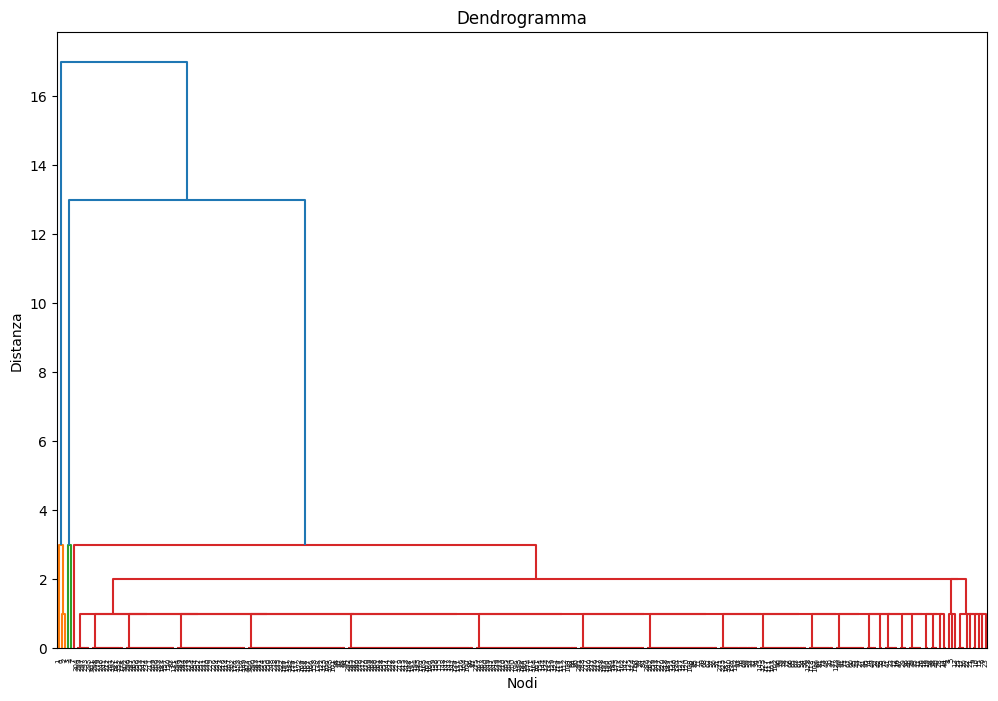

Esecuzione del clustering con il metodo: complete
  La modularità per il metodo complete è: 0.5009


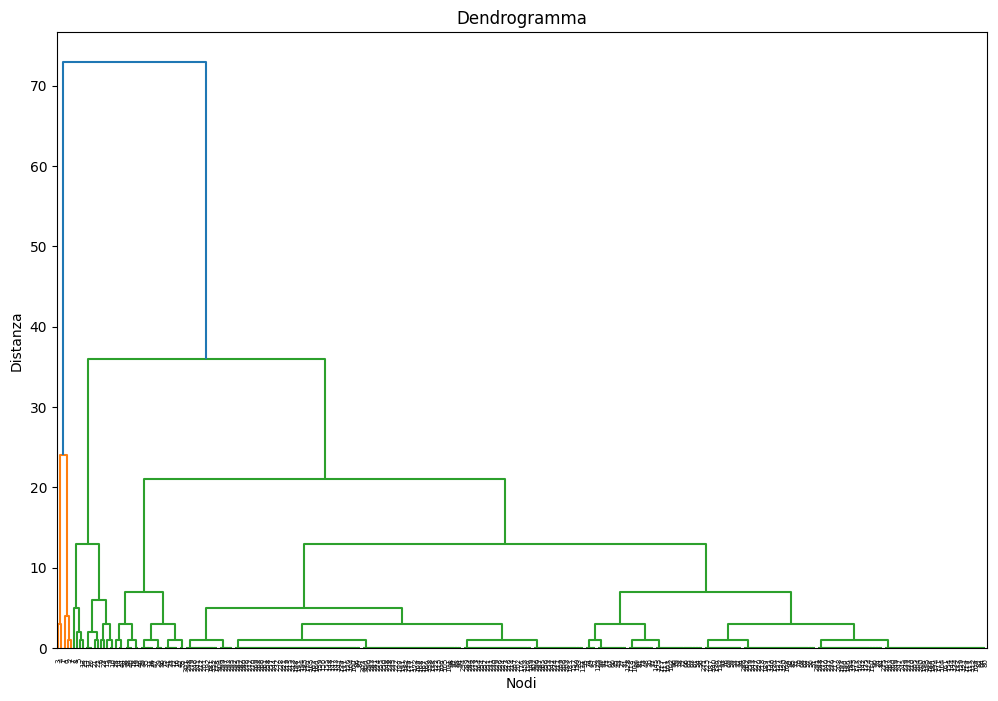

Esecuzione del clustering con il metodo: average
  La modularità per il metodo average è: 0.5009


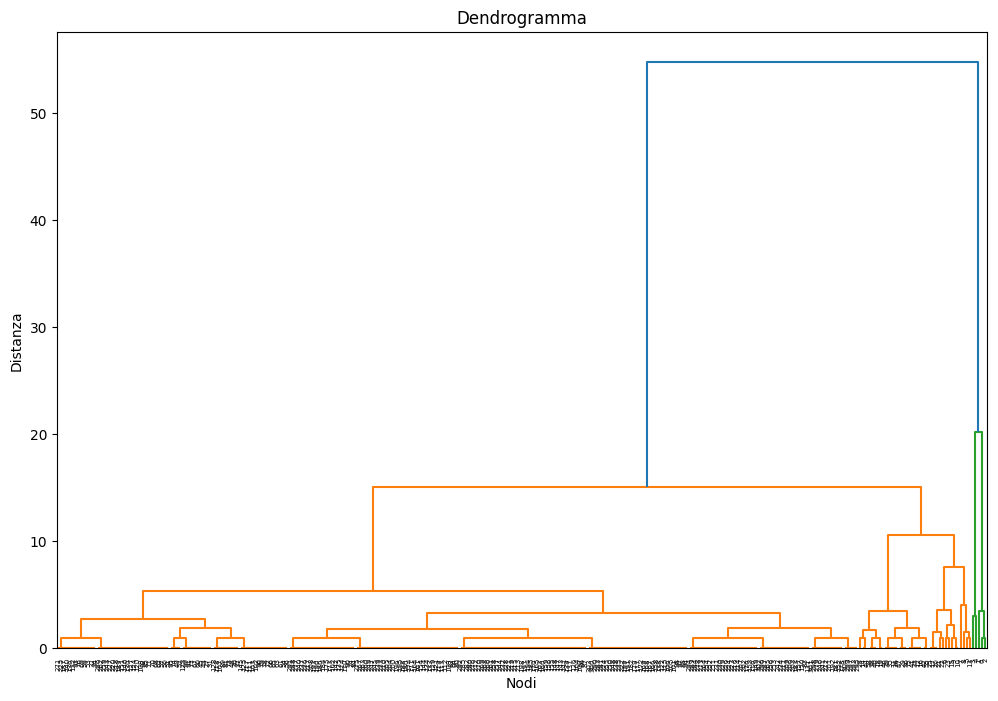

Esecuzione del clustering con il metodo: ward
  La modularità per il metodo ward è: 0.4990


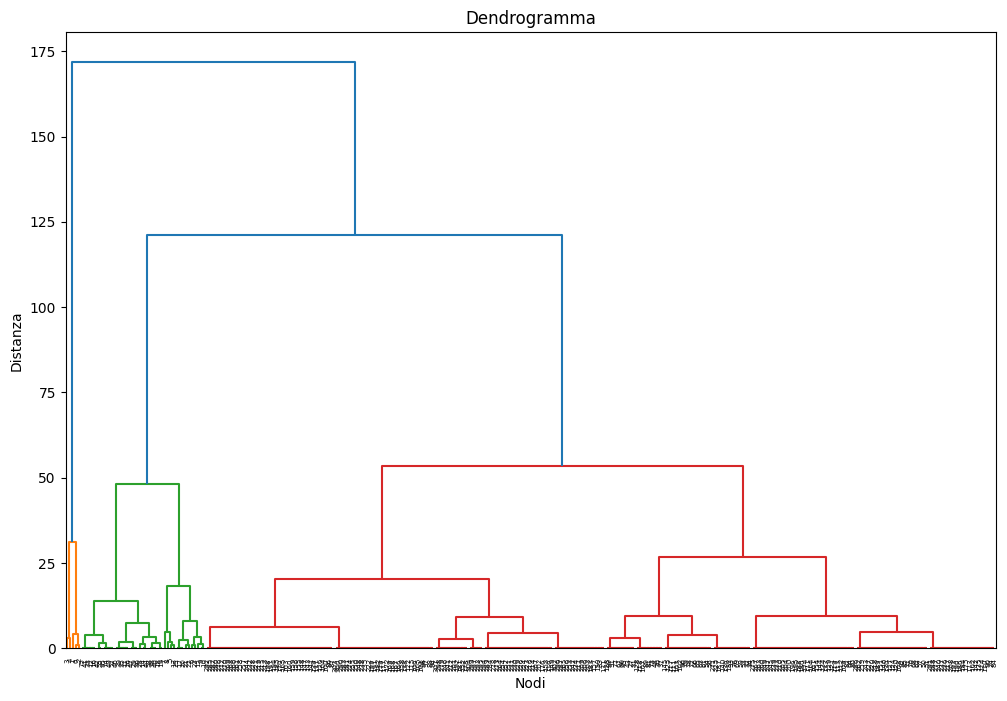

In [107]:
import networkx as nx
import matplotlib.pyplot as plt
import scipy.spatial.distance as ssd
import scipy.cluster.hierarchy as sch
import numpy as np
import pandas as pd
import community as community_louvain
# Carica i dati
nodes_df = pd.read_excel(r"C:\Users\Davvy\OneDrive\Desktop\polimi\erasmus\AAA_CURSOS\RSC\practica\P4\Nodes.xlsx", engine='openpyxl', header=0)
edges_df = pd.read_excel(r"C:\Users\Davvy\OneDrive\Desktop\polimi\erasmus\AAA_CURSOS\RSC\practica\P4\Musk_edges.xlsx", engine='openpyxl', header=0)

# 2. Creare il grafo ponderato da NetworkX
G = nx.Graph()

# Aggiungi i nodi
for _, row in nodes_df.iterrows():
    G.add_node(row['Id'], label=row['Label'])

# Aggiungi gli archi con pesi
for _, row in edges_df.iterrows():
    G.add_edge(row['Source'], row['Target'], weight=row['Weight'])

# 3. Calcolare i gradi ponderati (somma dei pesi degli archi)
node_degrees = np.array([sum([G[u][v]['weight'] for v in G[u]]) for u in G.nodes()])

# 4. Calcolare la matrice di distanza condensa tra i gradi ponderati
distance_matrix = ssd.pdist(node_degrees.reshape(-1, 1), metric='euclidean')

# Funzione per eseguire il clustering gerarchico con diverse opzioni di aggregazione
def hierarchical_clustering(distance_matrix, linkage_method):
    return sch.linkage(distance_matrix, method=linkage_method)

# Funzione per tracciare il dendrogramma
def plot_dendrogram(Z):
    plt.figure(figsize=(12, 8))
    sch.dendrogram(Z, orientation='top')
    plt.title('Dendrogramma')
    plt.xlabel('Nodi')
    plt.ylabel('Distanza')
    plt.show()

# Funzione per calcolare la modularità di un raggruppamento usando Louvain
def calculate_louvain_modularity(G):
    partition = community_louvain.best_partition(G)
    modularity = community_louvain.modularity(partition, G)
    return modularity, partition

# 5. 3 Opzioni di aggregazione (linkage)
methods = ['single', 'complete', 'average', 'ward']

# 6. Eseguiamo il clustering e calcoliamo la modularità per ogni metodo
for method in methods:
    print(f'Esecuzione del clustering con il metodo: {method}')
    Z = hierarchical_clustering(distance_matrix, method)
    
    # Calcoliamo la modularità con Louvain
    modularity, partition = calculate_louvain_modularity(G)
    
    print(f"  La modularità per il metodo {method} è: {modularity:.4f}")
    
    # Tracciamo il dendrogramma
    plot_dendrogram(Z)
